In [30]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from aotools import *
import matplotlib.patches as patches



%matplotlib inline

In [89]:
telescope_diameter = .356 # meter
central_obscuration =  .114 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
#spider_width = 0.05 # meter   ##spiders not mentioned in celestron site
oversizing_factor =  21/20 #147/128 #17 / 16  #NOT SURE
focallength_t = 3.910 #m
f_number = focallength_t/telescope_diameter 

focallength_l = 0.0145 #m
sh_pitch = .0005 #m
num_lenslets = 6 # lenslets along one diameter
sh_diameter = sh_pitch * num_lenslets #m
f_number_sh = focallength_l/sh_pitch
plate_scale = 0.55 #arcsec/pixel calculated in proposal doc
pixel_size = 3.45e-6 #m 
num_pupil_pixels = 1536 * oversizing_factor  # emccd is 2248x1536

wavelength = 0.55e-6  #NOT SURE
star_separation = 30 #in arcsec 

(2598544,) = num_pupil_pixel x num_pupil_pixel


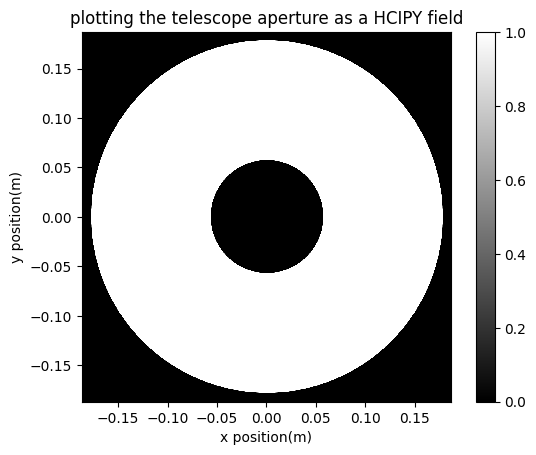

In [90]:
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid, 4)


print(shimm_aperture.shape, '= num_pupil_pixel x num_pupil_pixel')


imshow_field(shimm_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.title('plotting the telescope aperture as a HCIPY field')
plt.show()

In [91]:
pos_star = np.array([0.0, 0.0])  #np.array([4.84e-4,4.84e-4])

#wf = Wavefront(shimm_aperture, wavelength)
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)  
# is this to generalize wavefront based on arbitrary position of star and not just its centre ?
wf.total_power = 1

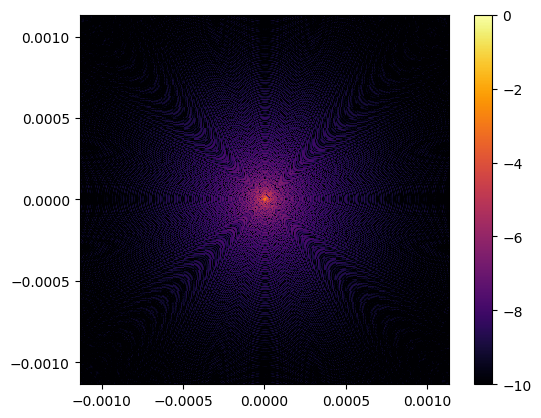

In [92]:
spatial_resolution = wavelength * f_number
focal_grid = make_focal_grid(q=5, num_airy=188, spatial_resolution=spatial_resolution)  
# required q is calculated from (spatial_resolution/pixel_size), comes out about 4.6. 
# Then num_airy is calculated by (num_lenslets*sh_pitch/spatial_reso), comes out 188 (should i use this?)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-10)
plt.colorbar()
plt.show()

#print(spatial_resolution)

0.003 in m is the sh_diameter = sh_pitch * num_lenslets
0.3738 in m is the diameter of the pupil plane just after telescope captures light
0.356 in m is the diameter of the telescope aperture, or in other words the diameter of illuminated plane
-0.0015 -0.001 -0.0005 0.0 0.0005 0.001 0.0015 are positions of edges of the lenslets along xaxis


<function matplotlib.pyplot.show(close=None, block=None)>

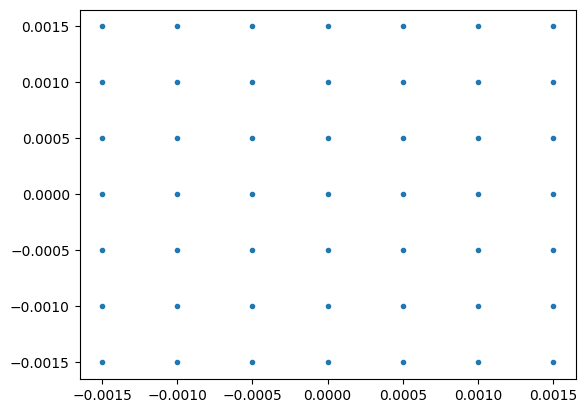

In [93]:

magnification = sh_diameter / pupil_grid_diameter
magnifier = Magnifier(magnification)

# shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number_sh, num_lenslets, sh_diameter)
# shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

# print(type(shwfs))
# print(np.array(shwfs))


'''
%%  source code

class SquareShackHartmannWavefrontSensorOptics(ShackHartmannWavefrontSensorOptics):
    ## Helper class to create a Shack-Hartmann WFS with square microlens array
    def __init__(self, input_grid, f_number, num_lenslets, pupil_diameter):
        lenslet_diameter = float(pupil_diameter) / num_lenslets
        x = np.arange(-pupil_diameter, pupil_diameter, lenslet_diameter)
        self.mla_grid = CartesianGrid(SeparatedCoords((x, x)))

        focal_length = f_number * lenslet_diameter
        self.micro_lens_array = MicroLensArray(input_grid, self.mla_grid, focal_length)

        ShackHartmannWavefrontSensorOptics.__init__(self, input_grid, self.micro_lens_array)
'''

print(sh_diameter, 'in m', 'is the sh_diameter = sh_pitch * num_lenslets')
print(pupil_grid_diameter, 'in m', 'is the diameter of the pupil plane just after telescope captures light')
print(telescope_diameter, 'in m', 'is the diameter of the telescope aperture, or in other words the diameter of illuminated plane')
lens_arr = np.arange(-sh_diameter/2, sh_diameter/2 + sh_pitch, sh_pitch) # we have rescaled the pupil plane to the sh plane
print(*lens_arr, 'are positions of edges of the lenslets along xaxis')

lens_grid = CartesianGrid(SeparatedCoords((lens_arr, lens_arr)))
plt.plot(lens_grid.x, lens_grid.y, '.')
plt.show





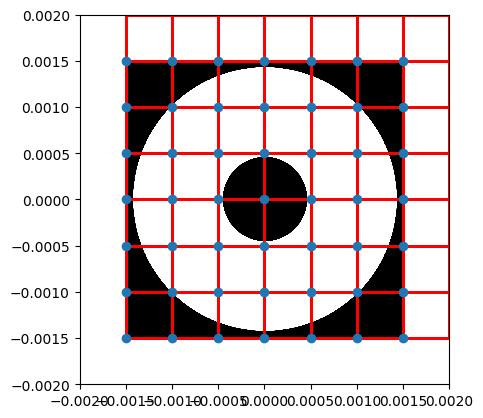

In [94]:
# what if we scale it with respect to the sh_diameter vs pupil_grid_diameter
scaler_new = sh_diameter / pupil_grid_diameter
new_pupil_grid = pupil_grid.scaled(scaler_new)
new_shimm_aperture_generator = make_obstructed_circular_aperture(scaler_new * telescope_diameter,central_obscuration_ratio)
new_shimm_aperture = evaluate_supersampled(new_shimm_aperture_generator, new_pupil_grid, 4)

fig, ax = plt.subplots()

imshow_field(new_shimm_aperture, cmap='gray')


for i in lens_grid.x:
    for j in lens_grid.y:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)


ax.plot(lens_grid.x, lens_grid.y, 'o')
ax.set_xlim([-0.002, 0.002])
ax.set_ylim([-0.002, 0.002])
plt.show()

# print(lens_grid.x)
# print(lens_grid.y)

In [95]:
from hcipy.optics import MicroLensArray
lenslet_array = MicroLensArray(pupil_grid.scaled(magnification), lens_grid, focallength_l)
SHWFS = ShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), lenslet_array)


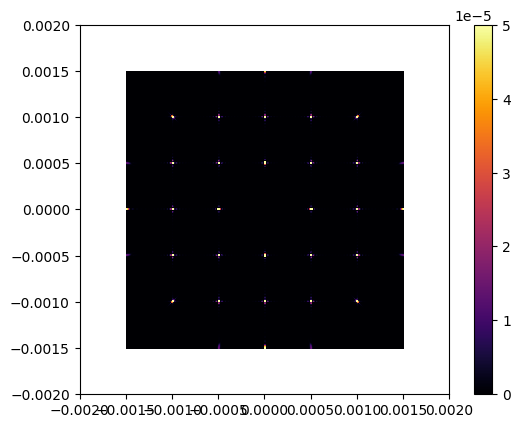

In [96]:
camera = NoiselessDetector(focal_grid)

pos_star = np.array([0.0, 0.0]) #[4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
#wf = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
wf.total_power = 1

camera.integrate(SHWFS(magnifier(wf)),1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno', vmax=5.0e-5)#, grid_units= pixel_size, vmax=5.0e-5)
#plt.imshow(image_ref.reshape((1764,1764)), cmap='inferno', vmax=1.0e-5)
plt.xlim(-0.002, 0.002)
plt.ylim(-0.002, 0.002)
plt.colorbar()
plt.show()


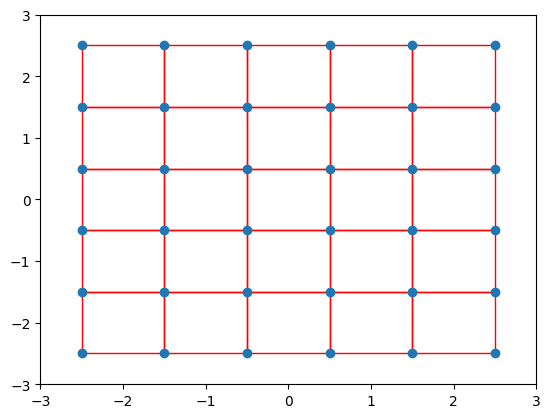

In [117]:
trial_grid = make_uniform_grid(6,[6,6])
fig, ax = plt.subplots()

# print(trial_grid.x, trial_grid.y)

x_pts = list(set(trial_grid.x))
y_pts = list(set(trial_grid.y)) 

x_pts = sorted(x_pts)
y_pts = sorted(y_pts)

# print(x_pts, y_pts)

ax.plot(trial_grid.x, trial_grid.y, 'o')

for i in x_pts[0:5]:
    for j in y_pts[0:5]:
        rectangle = patches.Rectangle((i, j), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
plt.show()